# Galaxy Zoo 2: Images

## Exploratory Data Analysis (EDA)

**Cel biznesowy**: Celem projektu jest sprawdzenie, czy można pogrupować obrazy galaktyk w typy kształtów galaktyk Hubble'a.

## Grupy galaktyk:

- *Ellipticals* : o kształtach od kulistych do cylindrycznych, o prawie jednorodnej gęstości
- *Spirals* : z dwoma lub więcej ramionami (jak w klasycznym widoku Galaktyki Drogi Mlecznej) i gęstym rdzeniem
- *Irregulars* : o nieokreślonym kształcie, o niejednorodnej gęstości
- *Lenticulars* : galaktyki w kształcie dysku z gęstym jądrem
- *Barred Spirals* : rodzaj spirali z prostymi ramionami blisko rdzenia i zakrzywionymi daleko od niego
- *Usual Spirals* : rodzaj spirali z wygiętymi ramionami od rdzenia do końca
- *Intermediate Spirals* : typ spirali o nieokreślonych ramionach
- *Dwarf Galaxy* : Mała nieregularna galaktyka heterogeniczna

In [4]:
import pandas as pd
import numpy as np 

In [15]:
metadane = pd.read_csv("gz2_filename_mapping.csv")
metadane.head(10)

,objid,sample,asset_id
0,587722981736120347,original,1
1,587722981736579107,original,2
2,587722981741363294,original,3
3,587722981741363323,original,4
4,587722981741559888,original,5
5,587722981741625481,original,6
6,587722981741625484,original,7
7,587722981741625520,original,8
8,587722981741625545,original,9
9,587722981741691055,original,10


In [16]:
len(metadane)

355990

In [17]:
metadane.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355990 entries, 0 to 355989
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   objid     355990 non-null  int64 
 1   sample    355990 non-null  object
 2   asset_id  355990 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 8.1+ MB


In [18]:
metadane.isnull().sum()

objid       0
sample      0
asset_id    0
dtype: int64

### W ramce danych nie ma żadnych nulli

In [19]:
metadane.describe()

,objid,asset_id
count,3.559900e+05,355990.000000
mean,1.961733e+18,177995.500000
std,3.030788e+18,102765.605502
min,5.877230e+17,1.000000
25%,5.877334e+17,88998.250000
50%,5.877399e+17,177995.500000
75%,5.880177e+17,266992.750000
max,8.647475e+18,355990.000000


In [22]:
# Rozkład wartości w kolumnie 'sample'
print(metadane['sample'].value_counts())

original            245609
stripe82_coadd_1     30346
stripe82_coadd_2     30339
extra                28174
stripe82             21522
Name: sample, dtype: int64


### Co zawierają kolejne kolumny?

**objid** - identyfikator obiektu Data Release 7 (DR7) dla każdej galaktyki

**sample** - ciąg wskazujący podpróbkowanie galaktyki

**asset_id** - liczba całkowita odpowiadająca nazwie pliku obrazu w spakowanym pliku

### Wczytanie obrazów

In [29]:
# Ścieżka do folderu z obrazami
images_path = 'images'

# Lista plików z obrazami JPG
image_files = [f for f in os.listdir(images_path) if f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.png')]

# Sprawdzenie kilku pierwszych nazw plików
print(image_files[:5])

['100.jpg', '1000.jpg', '10000.jpg', '100000.jpg', '100001.jpg']


(243434, 12288)


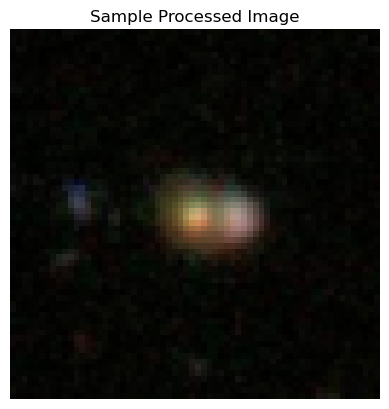

In [30]:
def preprocess_image(image_path, size=(64, 64)):
    try:
        with Image.open(image_path) as img:
            img = img.resize(size)
            img_array = np.array(img).flatten()
        return img_array
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# Przekształcenie wszystkich obrazów
image_data = []
for file in image_files:
    image_path = os.path.join(images_path, file)
    img_array = preprocess_image(image_path)
    if img_array is not None:
        image_data.append(img_array)

# Konwersja do formatu tablicy NumPy
image_data = np.array(image_data)

# Sprawdzenie kształtu przetworzonych danych
print(image_data.shape)

# Wyświetlenie przykładowego obrazu, jeśli dane są dostępne
if image_data.shape[0] > 0:
    sample_image = image_data[0].reshape((64, 64, -1))
    plt.imshow(sample_image)
    plt.title(f'Sample Processed Image')
    plt.axis('off')
    plt.show()

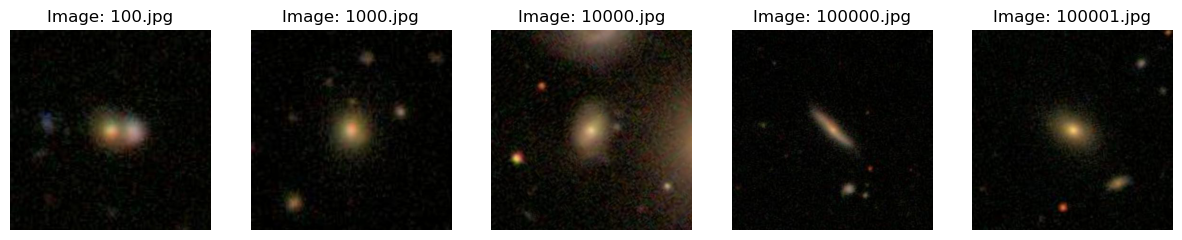

In [31]:
# Wyświetlenie kilku przykładowych obrazów
def plot_sample_images(image_files, images_path, n_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(n_samples):
        img_path = os.path.join(images_path, image_files[i])
        img = Image.open(img_path)
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(img)
        plt.title(f'Image: {image_files[i]}')
        plt.axis('off')
    plt.show()

plot_sample_images(image_files, images_path, n_samples=5)

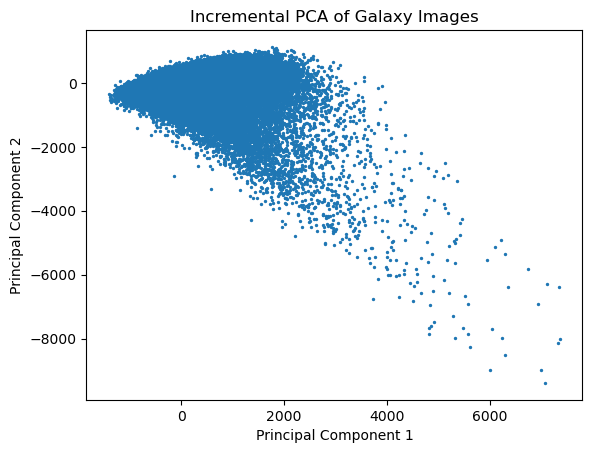

In [35]:
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

# Inicjalizacja IncrementalPCA
ipca = IncrementalPCA(n_components=2, batch_size=256)

# Przetwarzanie danych partiami
for i in range(0, image_data.shape[0], 256):
    batch = image_data[i:i+256]
    if i == 0:
        ipca.partial_fit(batch)
    else:
        ipca.partial_fit(batch)

# Przeprowadzenie transformacji na całym zbiorze danych
image_data_pca = np.zeros((image_data.shape[0], 2))
for i in range(0, image_data.shape[0], 256):
    batch = image_data[i:i+256]
    image_data_pca[i:i+256] = ipca.transform(batch)

# Wizualizacja wyników PCA
plt.scatter(image_data_pca[:, 0], image_data_pca[:, 1], s=2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Incremental PCA of Galaxy Images')
plt.show()

